In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import torch
import librosa
import whisper
import pandas as pd
import tensorflow_hub as hub
import ffmpeg
from tqdm import tqdm
from transformers import DistilBertTokenizer, DistilBertModel
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

2025-03-28 06:26:01.935417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-28 06:26:02.221883: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-28 06:26:03.291465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /media/zianraian/Work/anaconda3/opencv_build/install/lib:/usr/local/cuda-11.2/lib64::/usr/local/cuda/lib64
2025-03-28 06:26:03.291634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not loa

In [2]:
# Disable GPU for TensorFlow
tf.config.set_visible_devices([], 'GPU')
print("TensorFlow forced to use CPU (no GPU visible).")

# Create CPU device for PyTorch
device = torch.device("cpu")
print("PyTorch 'device' is set to:", device)


TensorFlow forced to use CPU (no GPU visible).
PyTorch 'device' is set to: cpu


2025-03-28 06:26:11.748653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-28 06:26:11.756090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-28 06:26:11.757106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# LOAD ALL MODELS ON CPU

# DistilBERT (PyTorch -> CPU)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert_model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)

# YAMNet (TensorFlow -> CPU)
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

# Whisper (PyTorch -> CPU)
whisper_model = whisper.load_model("base", device="cpu")

# MobileNetV2 (TensorFlow -> CPU)
video_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


/media/zianraian/Work/anaconda3/envs/deep_learning/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeq

In [4]:
# FEATURE EXTRACTION FUNCTIONS

def extract_text_embedding(text):
    """
    DistilBERT (PyTorch on CPU).
    """
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move to CPU
    with torch.no_grad():
        outputs = distilbert_model(**inputs)
    # shape: [batch_size, seq_len, hidden_dim]
    # Take [CLS] token
    return outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()

def extract_audio_embedding(video_path):
    """
    1) Convert .mp4 to .wav
    2) Load & resample to 16k with librosa
    3) YAMNet on CPU
    """
    audio_tmp = video_path.replace(".mp4", "_yamnet.wav")
    ffmpeg.input(video_path).output(audio_tmp, format="wav").run(overwrite_output=True)

    waveform, sr = librosa.load(audio_tmp, sr=16000)
    with tf.device("/CPU:0"):
        _, embeddings, _ = yamnet_model(waveform)
    return np.mean(embeddings.numpy(), axis=0)

def extract_video_embedding(video_path, num_frames=10):
    """
    1) Sample frames
    2) Convert frames to MobileNetV2 input
    3) Inference on CPU
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    indices = np.linspace(0, total_frames - 1, num_frames).astype(int)
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224)) / 255.0
        frames.append(frame)
    cap.release()

    if not frames:
        return np.zeros(1024)

    frames_arr = np.array(frames)
    # Force CPU usage for MobileNetV2
    with tf.device("/CPU:0"):
        embeddings = video_model.predict(frames_arr, batch_size=1, verbose=0)

    return np.mean(embeddings, axis=0)

def extract_text_from_video(video_path):
    """
    1) Convert .mp4 to .wav
    2) Run Whisper on CPU to transcribe
    """
    audio_tmp = video_path.replace(".mp4", "_whisper.wav")
    try:
        ffmpeg.input(video_path).output(audio_tmp, format="wav").run(overwrite_output=True)
        result = whisper_model.transcribe(audio_tmp)
        return result.get("text", "")
    except Exception as e:
        print(f"Whisper ASR failed for {video_path}: {e}")
        return ""


In [ ]:
# LOAD DATASET & EXTRACT FEATURES

data = []
dataset_path = "/home/zianraian/Dataset 499B"
categories = ["sarcastic", "non sarcastic"]

for category in categories:
    label = 1 if category == "sarcastic" else 0
    folder = os.path.join(dataset_path, category)

    for vid in tqdm(os.listdir(folder), desc=f"Processing {category}"):
        if not vid.endswith(".mp4"):
            continue
        path = os.path.join(folder, vid)

        try:
            text = extract_text_from_video(path)
            text_emb = extract_text_embedding(text)
            audio_emb = extract_audio_embedding(path)
            video_emb = extract_video_embedding(path)

            combined = np.concatenate([text_emb, audio_emb, video_emb])
            data.append({"video_id": vid, "embedding": combined, "label": label})
        except Exception as e:
            print(f"Error processing {vid}: {e}")
            continue

df = pd.DataFrame(data)
df.to_pickle("embeddings2.pkl")
df.to_csv("embeddings2.csv", index=False)


Processing sarcastic:   0%|                             | 0/790 [00:00<?, ?it/s]ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/media/zianraian/Work/anaconda3/envs/deep_learning --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/home/zia

In [8]:
# Model training
X = np.stack(df["embedding"].values)
y = np.array(df["label"].values)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(2, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_list = [
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)
]

Epoch 1/100
13/17 [=====================>........] - ETA: 0s - loss: 2.1769 - accuracy: 0.5337
Epoch 1: val_loss improved from inf to 1.80734, saving model to best_model.h5
17/17 [==============================] - 1s 29ms/step - loss: 2.1847 - accuracy: 0.5353 - val_loss: 1.8073 - val_accuracy: 0.6996 - lr: 1.0000e-04
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 2.0309 - accuracy: 0.5935
Epoch 2: val_loss improved from 1.80734 to 1.79056, saving model to best_model.h5
17/17 [==============================] - 0s 17ms/step - loss: 2.0309 - accuracy: 0.5935 - val_loss: 1.7906 - val_accuracy: 0.6996 - lr: 1.0000e-04
Epoch 3/100
16/17 [===========================>..] - ETA: 0s - loss: 2.0094 - accuracy: 0.6152
Epoch 3: val_loss improved from 1.79056 to 1.77522, saving model to best_model.h5
17/17 [==============================] - 0s 16ms/step - loss: 2.0089 - accuracy: 0.6164 - val_loss: 1.7752 - val_accuracy: 0.7300 - lr: 1.0000e-04
Epoch 4/100
14/17 [=============

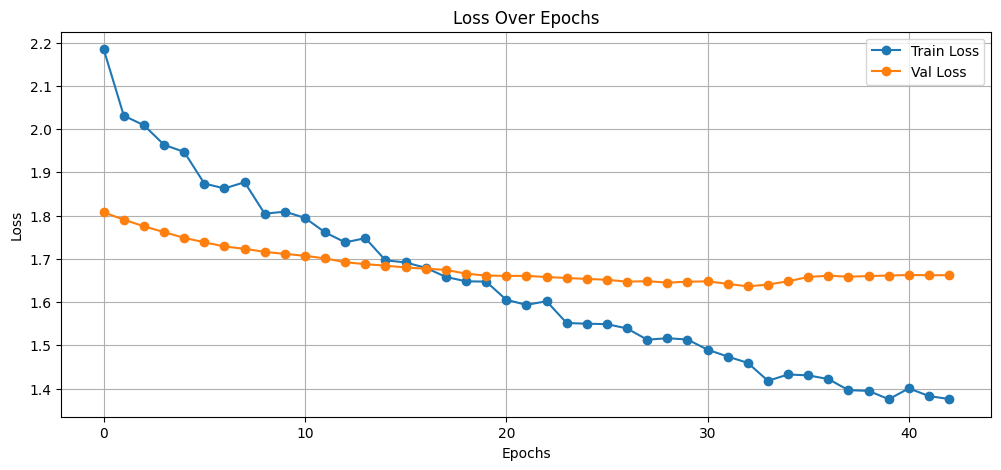

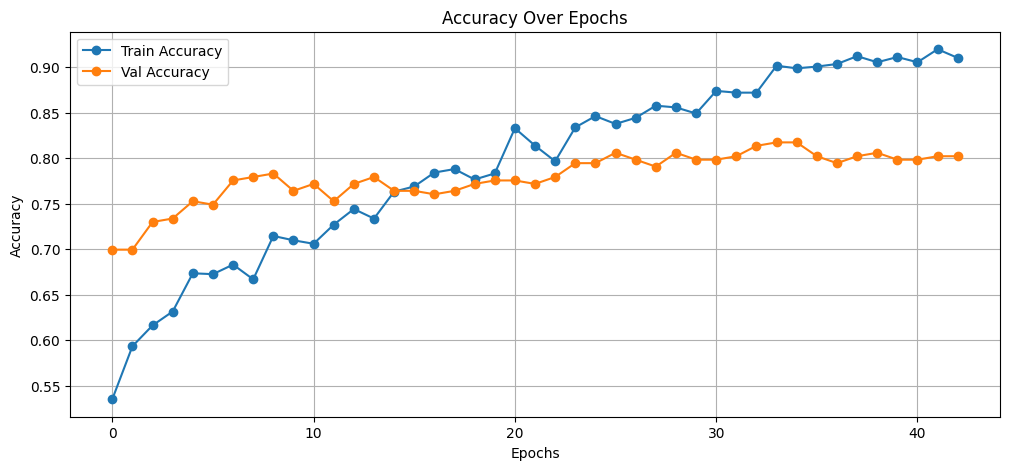

In [9]:
# Train model & store history
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks_list,
    verbose=1  # Ensures per-epoch output
)

# Extract values from training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Print results per epoch
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}/{len(train_loss)}")
    print(f"Train Loss: {train_loss[epoch]:.4f} | Val Loss: {val_loss[epoch]:.4f} | "
          f"Train Acc: {train_acc[epoch]*100:.2f}% | Val Acc: {val_acc[epoch]*100:.2f}%")
    print("-" * 60)

# Plot Loss Graph
plt.figure(figsize=(12, 5))
plt.plot(train_loss, label="Train Loss", marker="o")
plt.plot(val_loss, label="Val Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Graph
plt.figure(figsize=(12, 5))
plt.plot(train_acc, label="Train Accuracy", marker="o")
plt.plot(val_acc, label="Val Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()
